In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [25]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [3]:
dxx=0.5
dyy=dxx

In [4]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [5]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

#### Test - SST and Heatflux

In [6]:
chunks_new={'dayofyear':40}

In [9]:
%%time
chunks_new={'dayofyear':40}


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,:,300:-100].compute();
tf=tf[:,1:-1,1:-1]

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,:,300:-100].compute();
tt=tt[:,1:-1,1:-1]


CPU times: user 23.6 s, sys: 59.5 s, total: 1min 23s
Wall time: 2min 16s


In [10]:

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,:,300:-100].compute();
hf=hf[:,1:-1,1:-1]

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,:,300:-100].compute();
ht=ht[:,1:-1,1:-1]


In [11]:
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();

ust=vart.sustr.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();


vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();

vst=vart.svstr.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
vst=vst.compute();



usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,:,300:-100],vsf[:,:,300:-100]
ust,vst=ust[:,:,300:-100],vst[:,:,300:-100]


In [12]:
wstf=usf.copy()
wstt=ust.copy()


wstf.data=np.sqrt(usf.data**2+vsf.data**2)
wstt.data=np.sqrt(ust.data**2+vst.data**2)



In [13]:
mask_test=tf[0].to_numpy().copy()
# mask_test=varf.temp[0].to_numpy().copy()
mask=mask_test.copy()
mask[~np.isnan(mask_test)]=np.nan;
mask[np.isnan(mask_test)]=0;

In [14]:
print(tf.shape)
print(vst.shape)
print(ust.shape)

(214, 1518, 598)
(214, 1518, 598)
(214, 1518, 598)


In [15]:
t_ind[70]

<xarray.DataArray 'time_counter' ()>
array('2012-03-11T09:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    dayofyear  int64 71

In [177]:
indstart=126;
indend=131;

# indstart=55;
# indend=70;


up_tf=tf[indstart:indend].mean(axis=0)
up_tt=tt[indstart:indend].mean(axis=0)


up_hf=hf[indstart:indend].mean(axis=0)
up_ht=ht[indstart:indend].mean(axis=0)



up_usf=usf[indstart:indend].mean(axis=0)
up_ust=ust[indstart:indend].mean(axis=0)

up_vsf=vsf[indstart:indend].mean(axis=0)
up_vst=vst[indstart:indend].mean(axis=0)



up_wsf=wstf[indstart:indend].mean(axis=0)
up_wst=wstt[indstart:indend].mean(axis=0)


In [178]:
up_hf.max()

<xarray.DataArray 'shflx' ()>
array(-11.4225235, dtype=float32)

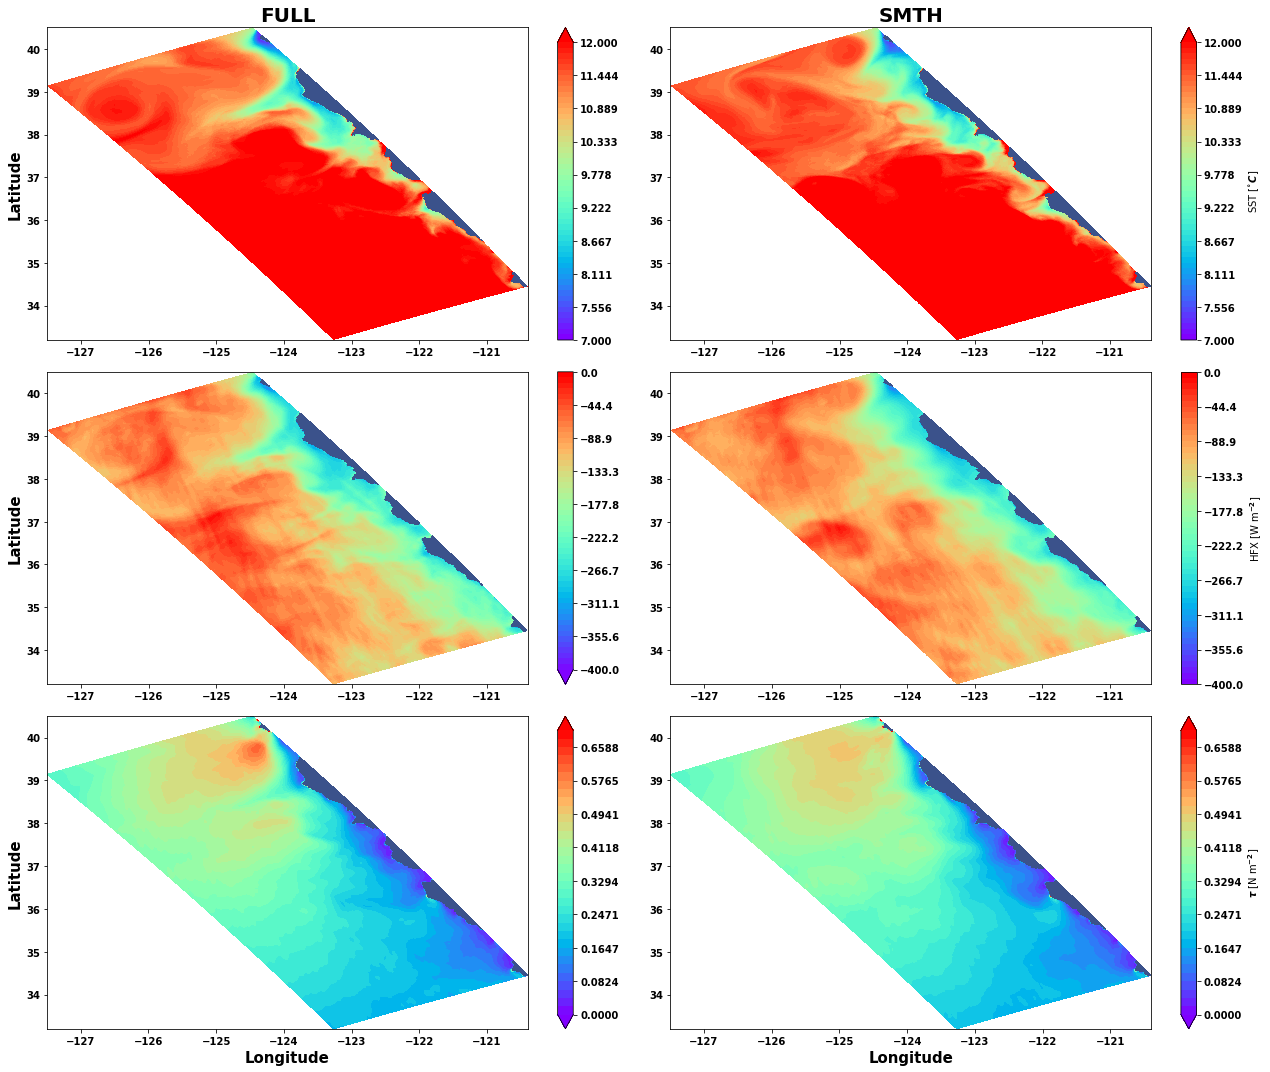

In [183]:
plt.figure(figsize=(18,15))
plt.subplot(3,2,1)
u1=up_tf.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(7,12,55),
             cbar_kwargs={'label':''})
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
plt.title('FULL',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('Latitude',fontsize=15,fontweight='bold')

plt.subplot(3,2,2)
u2=up_tt.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(7,12,55),
              cbar_kwargs={'label':r'SST [$^{\circ}C $]'})
plt.contourf(tt.nav_lon_rho,tt.nav_lat_rho,mask)
plt.title('SMTH',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('',fontsize=15,fontweight='bold')


plt.subplot(3,2,3)
u3=up_hf.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(-400,0,55),
             cbar_kwargs={'label':''})
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('FULL',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('Latitude',fontsize=15,fontweight='bold')

plt.subplot(3,2,4)
u4=up_ht.plot(x='nav_lon_rho',y='nav_lat_rho',cmap='rainbow',levels=np.linspace(-400,0,55),
              cbar_kwargs={'label':r'HFX [W m$^{-2}$]'})
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('SMTH',fontsize=20,fontweight='bold')
plt.xlabel('',fontsize=15,fontweight='bold')
plt.ylabel('',fontsize=15,fontweight='bold')



plt.subplot(3,2,5)
u5=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho.data,up_wsf,levels=np.linspace(0,0.7,35),extend='both',cmap='rainbow')
dec=50
# plt.quiver(tf.nav_lon_rho[::dec,::dec],tf.nav_lat_rho[::dec,::dec],up_usf[::dec,::dec],up_vsf[::dec,::dec])
plt.colorbar(u5)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('FULL',fontsize=20,fontweight='bold')
plt.xlabel('Longitude',fontsize=15,fontweight='bold')
plt.ylabel('Latitude',fontsize=15,fontweight='bold')


plt.subplot(3,2,6)
u6=plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho.data,up_wst,levels=np.linspace(0,0.7,35),extend='both',cmap='rainbow')
dec=50
# plt.quiver(tt.nav_lon_rho[::dec,::dec],tt.nav_lat_rho[::dec,::dec],up_ust[::dec,::dec],up_vst[::dec,::dec])
cb6=plt.colorbar(u6)
cb6.set_label(label=r'$\tau$ [N m$^{-2}$]')
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,mask)
# plt.title('SMTH',fontsize=20,fontweight='bold')
plt.xlabel('Longitude',fontsize=15,fontweight='bold')
plt.ylabel('',fontsize=15,fontweight='bold')

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/upwelling_front/upwelling_differences_{0}_{1}.png'.format(indstart,indend))




# Differences in T's over the front

In [28]:

chunk={'time_counter':20}


path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
wvarf=xr.open_mfdataset(listm[-7:],chunks=chunk,data_vars='minimal')


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
wvart=xr.open_mfdataset(listt[2:],chunks=chunk,data_vars='minimal')



In [142]:
wvarf

<xarray.Dataset>
Dimensions:               (y: 390, x: 300, lev_M: 49, lev_W: 50, time_counter: 213, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(390, 300), meta=np.ndarray>
  * lev_M                 (lev_M) float32 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0
  * lev_W                 (lev_W) float32 1.0 2.0 3.0 4.0 ... 48.0 49.0 50.0
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(20,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2012-01-01T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/28)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(20, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(20, 2), meta=np.ndarray>
    T2                    (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    Q2                    (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    RAINCV                (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    RAINNCV               (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    ...                    ...
    XKHH                  (time_counter, lev_M, y, x) float32 dask.array<chunksize=(20, 49, 390, 300), meta=np.ndarray>
    BN2                   (time_counter, lev_M, y, x) float32 dask.array<chunksize=(20, 49, 390, 300), meta=np.ndarray>
    AKMS                  (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    AKHS                  (time_counter, y, x) float32 dask.array<chunksize=(20, 390, 300), meta=np.ndarray>
    EXCH_H                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(20, 50, 390, 300), meta=np.ndarray>
    EXCH_M                (time_counter, lev_W, y, x) float32 dask.array<chunksize=(20, 50, 390, 300), meta=np.ndarray>
Attributes: (12/100)
    name:                            Out/wrf_3D_Y2012M01_DAY
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    Conventions:                     CF-1.6
    timeStamp:                       2020-Jul-30 22:34:33 GMT
    uuid:                            42198aea-d8e9-4067-956c-4346ac67e533
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [143]:
%%time
chunks_new={'time_counter':40}

atf=wvarf.T2
atf=atf.chunk(chunks=chunks_new);
atf=atf[:,30:-30,30:200].compute()-273.15;
# atf=atf[:,1:-1,1:-1]

att=wvart.T2
att=att.chunk(chunks=chunks_new);
att=att[:,30:-30,30:200].compute()-273.15;
# att=att[:,1:-1,1:-1]


sstf=wvarf.SST
sstf=sstf.chunk(chunks=chunks_new);
sstf=sstf[:,30:-30,30:200].compute()-273.15;
# atf=atf[:,1:-1,1:-1]

sstt=wvart.SST
sstt=sstt.chunk(chunks=chunks_new);
sstt=sstt[:,30:-30,30:200].compute()-273.15;
# att=att[:,1:-1,1:-1]


shtf=wvarf.HFX
shtf=shtf.chunk(chunks=chunks_new);
shtf=shtf[:,30:-30,30:200].compute();
# atf=atf[:,1:-1,1:-1]

shtt=wvart.HFX
shtt=shtt.chunk(chunks=chunks_new);
shtt=shtt[:,30:-30,30:200].compute();
# att=att[:,1:-1,1:-1]


lhtf=wvarf.LH
lhtf=lhtf.chunk(chunks=chunks_new);
lhtf=lhtf[:,30:-30,30:200].compute();
# atf=atf[:,1:-1,1:-1]

lhtt=wvart.LH
lhtt=lhtt.chunk(chunks=chunks_new);
lhtt=lhtt[:,30:-30,30:200].compute();
# att=att[:,1:-1,1:-1]


wspf=wvarf.WSPD10
wspf=wspf.chunk(chunks=chunks_new);
wspf=wspf[:,30:-30,30:200].compute();

wspt=wvart.WSPD10
wspt=wspt.chunk(chunks=chunks_new);
wspt=wspt[:,30:-30,30:200].compute();


CPU times: user 840 ms, sys: 426 ms, total: 1.27 s
Wall time: 9.12 s


# x-section

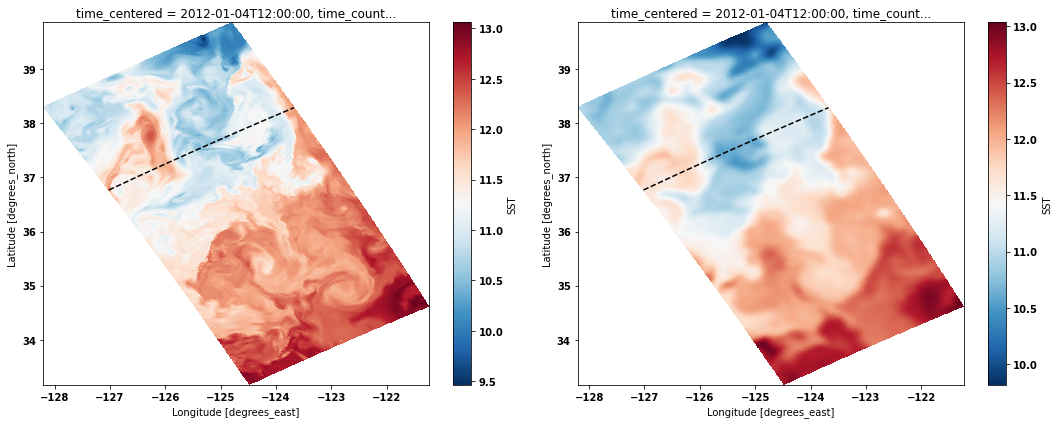

In [119]:
upst=3

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sstf[upst].plot(x='nav_lon',y='nav_lat',cmap='RdBu_r')
plt.plot(sstf.nav_lon[-100,:],sstf.nav_lat[-100,:],'k--')
plt.subplot(1,2,2)
sstt[upst].plot(x='nav_lon',y='nav_lat',cmap='RdBu_r')
plt.plot(sstt.nav_lon[-100,:],sstt.nav_lat[-100,:],'k--')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

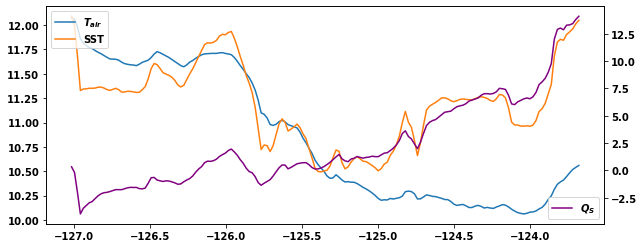

<Figure size 432x288 with 0 Axes>

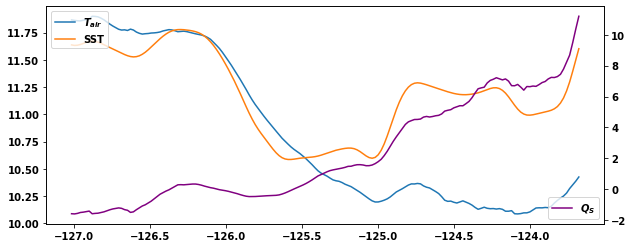

In [120]:
plt.figure()

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(atf.nav_lon[-100,:],atf[upst,-100,:],label=r'$T_{air}$')
ax1.plot(sstf.nav_lon[-100,:],sstf[upst,-100,:],label='SST')
plt.legend(loc=2)

ax2=ax1.twinx()

# ax2.plot(shtf.nav_lon[-100,:],(shtf+lhtf)[upst,-100,:],color='green',label=r'$Q_{S} + Q_{L}$')
ax2.plot(shtf.nav_lon[-100,:],(shtf)[upst,-100,:],color='purple',label=r'$Q_{S} $')
# ax2.plot(shtf.nav_lon[-100,:],(lhtf)[upst,-100,:],color='navy',label=r'$Q_{L} $')
plt.legend(loc=4)



plt.figure()
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(att.nav_lon[-100,:],att[upst,-100,:],label=r'$T_{air}$')
ax1.plot(sstt.nav_lon[-100,:],sstt[upst,-100,:],label='SST')
plt.legend(loc=2)

ax2=ax1.twinx()

# ax2.plot(shtt.nav_lon[-100,:],(shtt+lhtt)[upst,-100,:],color='green',label=r'$Q_{S} + Q_{L}$')
ax2.plot(shtt.nav_lon[-100,:],(shtt)[upst,-100,:],color='purple',label=r'$Q_{S}$')
# ax2.plot(shtt.nav_lon[-100,:],(lhtt)[upst,-100,:],color='navy',label=r'$Q_{L}$')




plt.legend(loc=4)

# y-section

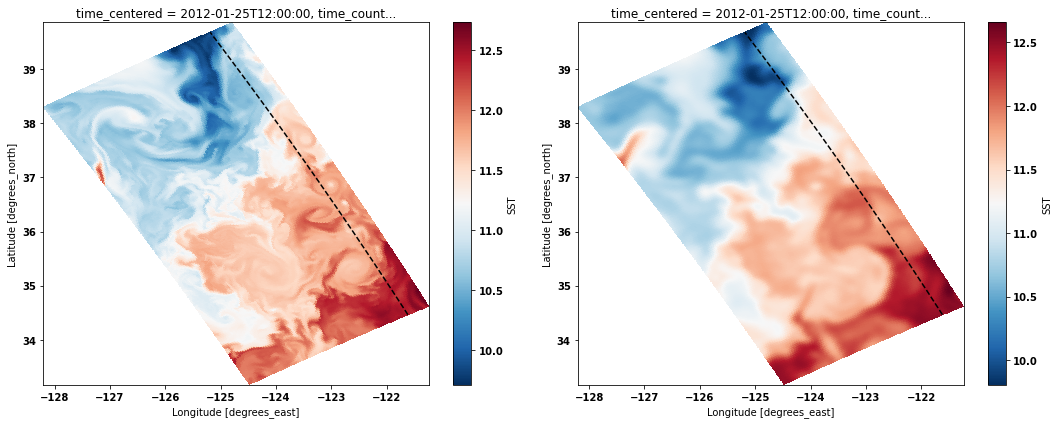

In [159]:
upst=24
sec=-20
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sstf[upst].plot(x='nav_lon',y='nav_lat',cmap='RdBu_r')
plt.plot(sstf.nav_lon[:,sec],sstf.nav_lat[:,sec],'k--')
plt.subplot(1,2,2)
sstt[upst].plot(x='nav_lon',y='nav_lat',cmap='RdBu_r')
plt.plot(sstt.nav_lon[:,sec],sstt.nav_lat[:,sec],'k--')

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

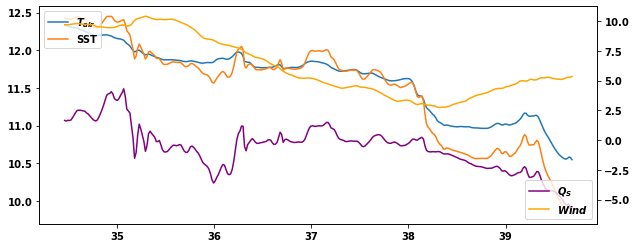

<Figure size 432x288 with 0 Axes>

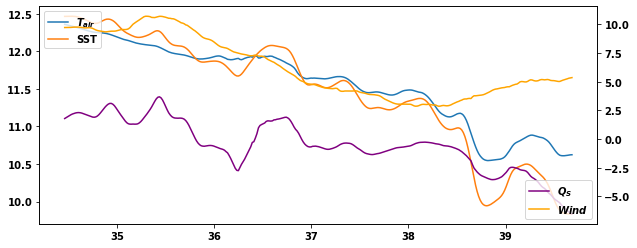

In [190]:
plt.figure()
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(atf.nav_lat[:,sec],atf[upst,:,sec],label=r'$T_{air}$')
ax1.plot(sstf.nav_lat[:,sec],sstf[upst,:,sec],label='SST')
plt.legend(loc=2)

ax2=ax1.twinx()

# ax2.plot(shtf.nav_lat[:,sec],(shtf+lhtf)[upst,:,sec],color='green',label=r'$Q_{S} + Q_{L}$')
ax2.plot(shtf.nav_lat[:,sec],(shtf)[upst,:,sec],color='purple',label=r'$Q_{S} $')
# ax2.plot(shtf.nav_lat[:,sec],(lhtf)[upst,:,sec],color='navy',label=r'$Q_{L} $')

ax2.plot(wspf.nav_lat[:,sec],wspf[upst,:,sec],color='orange',label=r'$Wind$')
plt.legend(loc=4)



plt.figure()
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(att.nav_lat[:,sec],att[upst,:,sec],label=r'$T_{air}$')
ax1.plot(sstt.nav_lat[:,sec],sstt[upst,:,sec],label='SST')
plt.legend(loc=2)

ax2=ax1.twinx()

# ax2.plot(shtt.nav_lat[:,sec],(shtt+lhtt)[upst,:,sec],color='green',label=r'$Q_{S} + Q_{L}$')
ax2.plot(shtt.nav_lat[:,sec],(shtt)[upst,:,sec],color='purple',label=r'$Q_{S}$')
# ax2.plot(shtt.nav_lat[:,sec],(lhtt)[upst,:,sec],color='navy',label=r'$Q_{L}$')

ax2.plot(wspt.nav_lat[:,sec],wspt[upst,:,sec],color='orange',label=r'$Wind$')

plt.legend(loc=4)








# Interpolated for Correlation

In [181]:
tlist=[]
for ii in range(tf.nav_lat_rho.shape[1]):
    tlist.append((sstf.nav_lat[:,sec].mean().data-tf.nav_lat_rho[:,ii].mean().data).sum())
ind=np.argmin(tlist)

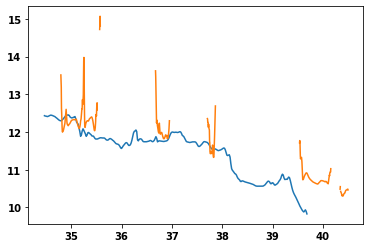

In [184]:
plt.figure()
plt.plot(sstf.nav_lat[:,sec],sstf[upst,:,sec])
plt.plot(tf.nav_lat_rho[:,ind],tf[upst,:,ind])

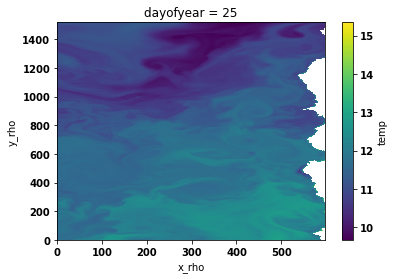

In [187]:
tf[upst].plot()